# Difference in difference analysis to estimate impact of CICIG on Guatemala's homicide rates



In [124]:
import pandas as pd
import matplotlib as mlp
from matplotlib import pyplot as plt
import numpy as np 
import seaborn as sbs
from statsmodels import api as stm
sbs.set(style="whitegrid")
%matplotlib inline

In [2]:
def tryFunc(functionToTry, onError = np.NaN, showErrors = False):
    def wrapper(inputValue):
        try:
            return functionToTry(inputValue)
        except:
            if showErrors:
                print("Bad value: ", inputValue)
            return onError
    return wrapper

toFloat = lambda x: float(x)

In [3]:
gt1 = pd.read_excel("./guatemala1.xlsx")

In [4]:
gt1.head(3)

,Series Name,Series Code,Country Name,Country Code,YR1990,YR2000,YR2001,YR2002,YR2003,YR2004,...,YR2008,YR2009,YR2010,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017
0,homicide,VC.IHR.PSRC.P5,Costa Rica,CRI,..,6.3,6.4,6.3,7.3,6.7,...,11.6,11.7,11.6,10.3,8.7,8.7,10,11.8,..,..
1,homicide,VC.IHR.PSRC.P5,Cuba,CUB,..,..,5.4,5.9,5.7,5.9,...,4.6,5,4.5,4.7,..,..,..,..,..,..
2,homicide,VC.IHR.PSRC.P5,El Salvador,SLV,..,40.3,37.8,37.9,37.2,46.8,...,52.9,72.8,66,72.2,42.7,41.3,64.2,108.6,..,..


In [5]:
gtpop = pd.read_excel("./gtm_pop.xlsx")

In [6]:
gtpop.head(3)

,year,GTM_population,GTM_pop100k
0,2007,13700286,137.00286
1,2008,14006366,140.06366
2,2009,14316208,143.16208


In [7]:
gt1 = gt1[gt1["Country Code"].isin(["CUB", "HTI"]) == False]

In [8]:
gt1.head()

,Series Name,Series Code,Country Name,Country Code,YR1990,YR2000,YR2001,YR2002,YR2003,YR2004,...,YR2008,YR2009,YR2010,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017
0,homicide,VC.IHR.PSRC.P5,Costa Rica,CRI,..,6.3,6.4,6.3,7.3,6.7,...,11.6,11.7,11.6,10.3,8.7,8.7,10,11.8,..,..
2,homicide,VC.IHR.PSRC.P5,El Salvador,SLV,..,40.3,37.8,37.9,37.2,46.8,...,52.9,72.8,66,72.2,42.7,41.3,64.2,108.6,..,..
3,homicide,VC.IHR.PSRC.P5,Dominican Republic,DOM,..,14.1,12.6,14.5,21.2,24.6,...,24.8,24.3,25,25.1,22.3,..,17.4,..,..,..
4,homicide,VC.IHR.PSRC.P5,Honduras,HND,..,50.9,54.7,55.7,61.5,53.9,...,61.4,71.5,83.1,93.2,92.7,81.9,74.6,63.8,..,..
5,homicide,VC.IHR.PSRC.P5,Guatemala,GTM,..,24.8,27,29.6,33.7,35,...,44.6,45.1,40.5,37.7,33.5,33.5,31.2,..,..,..


In [9]:
gt1["Series Name"].value_counts()

CPIA_public_sector                10
under5_mortality_rate             10
homicide                          10
poverty_headcount_320             10
gdp_per_capita_ppp_2011           10
household_consumption             10
CPIA_accountability_corruption    10
youth_literacy_rate               10
adult_literacy_rate               10
Name: Series Name, dtype: int64

In [10]:
cols = gt1.columns[gt1.columns.map(lambda x: x.startswith("YR")) == True]
gt2 = gt1.set_index(["Country Code", "Series Name"])[cols].stack().map(tryFunc(toFloat)).unstack(1).rename(index=lambda x: int(x[2:6]) if str.startswith(x, "YR") else x)

In [11]:
gt2.head().reset_index()

Series Name,Country Code,level_1,CPIA_accountability_corruption,CPIA_public_sector,adult_literacy_rate,gdp_per_capita_ppp_2011,homicide,household_consumption,poverty_headcount_320,under5_mortality_rate,youth_literacy_rate
0,COL,1990,NaN,NaN,NaN,7533.518385,NaN,2894.417281,NaN,35.1,NaN
1,COL,2000,NaN,NaN,NaN,8308.222950,65.7,3101.881202,28.8,25.0,NaN
2,COL,2001,NaN,NaN,NaN,8327.070759,67.9,3105.015716,38.2,24.3,NaN
3,COL,2002,NaN,NaN,NaN,8415.759119,68.3,3122.136969,29.8,23.6,NaN
4,COL,2003,NaN,NaN,NaN,8625.246570,53.4,3170.331340,27.7,22.9,NaN


In [12]:
# This gives the same that stata
del gt2["CPIA_accountability_corruption"]
del gt2["CPIA_public_sector"]
gt2[gt2.index.get_level_values(1) < 2007].describe()

Series Name,adult_literacy_rate,gdp_per_capita_ppp_2011,homicide,household_consumption,poverty_headcount_320,under5_mortality_rate,youth_literacy_rate
count,20.000000,80.000000,69.000000,79.000000,56.000000,80.00000,20.000000
mean,87.666931,8599.024509,28.108696,3245.349387,24.321429,30.63875,94.577347
std,6.772482,3851.423356,19.192383,1502.428044,10.644806,13.38700,4.636641
min,69.101730,3003.519024,6.300000,1102.633868,9.900000,10.30000,82.220260
25%,86.137218,6070.409423,10.400000,2175.455903,16.525000,22.07500,94.767635
50%,90.405135,8238.534249,24.800000,3105.015716,23.150000,27.80000,96.346065
75%,91.999635,11090.964672,43.600000,4265.429084,28.500000,37.32500,97.619985
max,94.868190,16149.480338,68.300000,6815.420781,64.300000,81.80000,97.991310


In [13]:
cols = ["gdp_per_capita_ppp_2011", "homicide", "household_consumption", "poverty_headcount_320"]
gt2["intercept"] = 1
def trends(df):
    results = []
    for col in cols:
        results.append(np.linalg.lstsq(df[df[col].isna() == False].reset_index()[["intercept", "level_1"]], df[df[col].isna() == False][col])[0][1])
    return pd.Series(index = cols, data = results)
trends = gt2[(gt2.index.get_level_values(1) < 2007 )].groupby("Country Code").apply(trends)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [14]:
# The trends for each country for each indicator
# This is showing the same results as the original file.
trends

,gdp_per_capita_ppp_2011,homicide,household_consumption,poverty_headcount_320
Country Code,,,,
COL,121.033285,-5.971429,31.783762,-1.597143
CRI,225.242755,0.314286,72.978773,-0.589339
DOM,239.545720,2.253571,83.524545,0.753571
GTM,80.325020,3.101429,34.219756,0.216667
HND,36.268825,-1.321429,14.579777,-1.480016
MEX,178.282345,-0.207143,116.731212,-2.510000
NIC,50.276370,0.671429,19.355949,-2.625000
PAN,272.126317,0.100000,105.051787,-0.796429
SLV,161.672645,4.885714,83.784653,-0.903571


In [15]:
trends.columns = trends.columns.map(lambda x: "trend_" + x)

In [16]:
trends = pd.concat([trends, gt2[gt2.index.get_level_values(1) < 2007].groupby(level=[0]).mean()], axis = 1)

In [17]:
trends.to_csv("trends.csv")

In [18]:
gt2.to_csv("data_time_series.csv")

# Comparing Guatemala with the Synthetic Control

Now reading the weights generated by ebalance package in R


In [19]:
ebal_st = pd.read_csv("./ebalanced_stata.csv", index_col=0)
ebal_st.loc["GTM"] = 1
ebal_st.columns = ["ebal_st"]
ebal_R = pd.read_csv("./ebalanced.csv", index_col=0)
ebal_R.loc["GTM"] = 1
ebal_R.columns = ["ebal_R"]

In [61]:
gt3 = gt2.reset_index()
gt3 = gt2.merge(ebal_st, left_on="Country Code", right_index=True).reset_index()
gt3 = gt3.merge(ebal_R, left_on="level_0", right_index=True)
gt3["logHom"] = np.log10(gt3.homicide)
gt3["Treatment"] = gt3.level_0 == "GTM"

In [65]:
def wmean(df, m, w):
    return df[m].multiply(df[w]).sum() / \
                df[w][df[m].notna()].sum()

# TEST
# wmean(gt3[gt3.level_0 == "GTM"], "homicide", "ebal_st" ), gt3[gt3.level_0 == "GTM"].homicide.mean()


In [64]:
avgCols = ['logHom','adult_literacy_rate', 'gdp_per_capita_ppp_2011', 'homicide',
        'household_consumption', 'poverty_headcount_320',
        'under5_mortality_rate', 'youth_literacy_rate']
gt4_st = gt3.groupby(["Treatment", "level_1"]).apply(
    lambda x: pd.Series([ wmean(x, col, "ebal_st") for col in avgCols ], avgCols) )
gt4_R  = gt3.groupby(["Treatment", "level_1"]).apply(
    lambda x: pd.Series([ wmean(x, col, "ebal_R") for col in avgCols ], avgCols) )

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


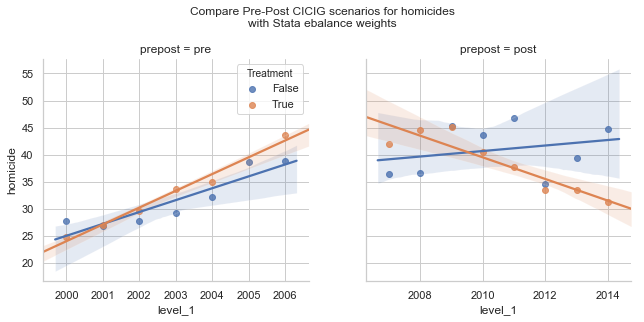

In [121]:
gt4_st["prepost"] = gt4_st.index.get_level_values(1).map(lambda x: ("pre" if x<2007 else "post"), 1)
sbs.lmplot("level_1", "homicide", gt4_st[gt4_st.index.get_level_values(1).isin(list(range(2000, 2015)))]\
               .reset_index(), "Treatment", col = "prepost", sharex=False, legend_out=False)
# Finally, getting the same graph that CrisisGroup obtained in stata, of course, using their ebalance results.
plt.suptitle("Compare Pre-Post CICIG scenarios for homicides\nwith Stata ebalance weights")
plt.tight_layout(4.5)

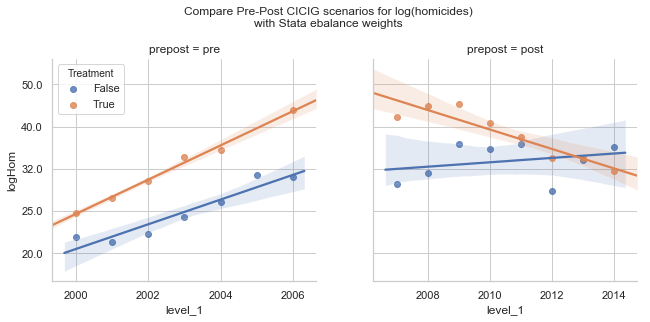

In [120]:
axs = sbs.lmplot("level_1", "logHom", gt4_st[gt4_st.index.get_level_values(1).isin(list(range(2000, 2015)))]\
               .reset_index(), "Treatment", col = "prepost", sharex=False, legend_out=False)
plt.suptitle("Compare Pre-Post CICIG scenarios for log(homicides)\nwith Stata ebalance weights")
plt.tight_layout(4.5)
axs.set_yticklabels(np.power(10, a.get_yticks()).round())

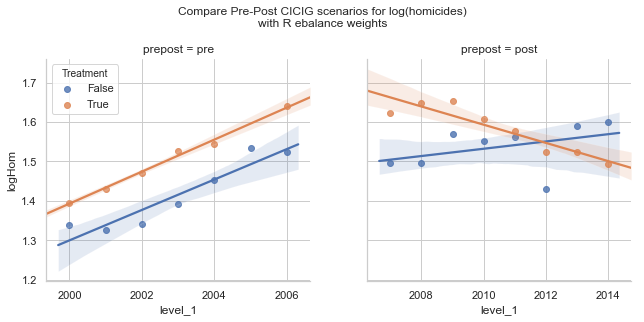

In [122]:
gt4_R["prepost"] = gt4_R.index.get_level_values(1).map(lambda x: ("pre" if x<2007 else "post"), 1)
sbs.lmplot("level_1", "logHom", gt4_R[gt4_R.index.get_level_values(1).isin(list(range(2000, 2015)))]\
               .reset_index(), "Treatment", col = "prepost", sharex=False, legend_out=False)
plt.suptitle("Compare Pre-Post CICIG scenarios for log(homicides)\nwith R ebalance weights")
plt.tight_layout(4.5)

In [204]:
gt4_R["Tx"] = gt4_R.index.get_level_values(0).astype(int)
gt4_R["After"] = (gt4_R["prepost"] == "post").astype(int)
reg = stm.GLM.from_formula("homicide ~ After + Tx*After - Tx+ C(level_1)", gt4_R.reset_index())
fit = reg.fit()
print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               homicide   No. Observations:                   30
Model:                            GLM   Df Residuals:                       13
Model Family:                Gaussian   Df Model:                           16
Link Function:               identity   Scale:                          19.182
Method:                          IRLS   Log-Likelihood:                -74.334
Date:                Mon, 21 Jan 2019   Deviance:                       249.37
Time:                        11:03:36   Pearson chi2:                     249.
No. Iterations:                     3   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             30.5562      0.995     30.703      0.000      28.606      32.507
C(level_1)[T.2000]    -4.781

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [205]:
print("Net avoided homicides (using R ebalance and Python GLM)")
(gtpop.GTM_pop100k * fit.params["Tx:After"]).sum()

Net avoided homicides (using R ebalance and Python GLM)


-5067.841139865544

In [206]:
gt4_st["Tx"] = gt4_st.index.get_level_values(0).astype(int)
gt4_st["After"] = (gt4_st["prepost"] == "post").astype(int)
reg = stm.GLM.from_formula("homicide ~ After + Tx*After - Tx + C(level_1)", gt4_st.reset_index())
fit = reg.fit()
print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               homicide   No. Observations:                   30
Model:                            GLM   Df Residuals:                       13
Model Family:                Gaussian   Df Model:                           16
Link Function:               identity   Scale:                          16.159
Method:                          IRLS   Log-Likelihood:                -71.761
Date:                Mon, 21 Jan 2019   Deviance:                       210.06
Time:                        11:03:44   Pearson chi2:                     210.
No. Iterations:                     3   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             30.0014      0.913     32.845      0.000      28.211      31.792
C(level_1)[T.2000]    -3.766

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [208]:
print("Net avoided homicides (using Stata ebalance and Python GLM)")
(gtpop.GTM_pop100k * fit.params["Tx:After"]).sum()
# Crisis Group result in using stata GLM with robust variance is  4658 

Net avoided homicides (using Stata ebalance and Python GLM)


-4076.822395277368